# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS 

import wordcloud

C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

##  Data Import and Preprocessing

**Load preprocessed 'final' data**

In [3]:
final = pickle.load(open('preprocessed_final', 'rb'))

 *Checkpoint 2: Data is now sorted based on Time and preprocessed.*

In [4]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [5]:
type(X)

numpy.ndarray

In [6]:
type(y)

numpy.ndarray

In [5]:
# ss
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [6]:
del final, X, y

In [9]:
print("Train Set:",X_train.shape, y_train.shape[0])
print("Test Set:",X_test.shape, y_test.shape[0])

Train Set: (61441,) 61441
Test Set: (26332,) 26332


*Checkpoint 3: Data has been partioned into train, cv and test*

**Defining functions that we will be using throughout the notebook for BoW, TFIDF, AvgW2V, TFIDF-WW2V**


**hyperparameter tuning**

In [7]:
# the values of hyoperparameters are inspired from this blog: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
def get_best_hyperparameters_rf(vectorizer, X_train, X_test, y_train, y_test):
  
    """
    This funtion takes in the vectorizer,  and performs DecisionTreeClassifier hyperparameter tuning using GridSearchCV with 5 fold cv 
    Returns the value of hyperparameter alpha and draws the error plot for various values of alpha
  
    Usage: get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)
    """
      
    params_dict = {
               "max_depth": [2,3,4,5,6,7,8,9,10], 
                "n_estimators": [5,10,50,100,200,500,1000]
                 
                  }
    
    clf = RandomForestClassifier(random_state= 507)
   
    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

    gs_obj.fit(X_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    #print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
    #plotting heatmap
    # https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
    plt.figure(1)
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
    
    ax = sns.heatmap(pvt,annot = True)
    ax.set_title("CV set results")
    
    plt.subplot(122) 
    pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
    
    ax2 = sns.heatmap(pvt2,annot = True, )
    ax2.set_title('training set results')
    

In [8]:
def get_best_hyperparameters_lgbm(vectorizer, X_train, X_test, y_train, y_test):
       
    params_dict = {
                "max_depth": [2,3,4,5,6,7,8,9,10], 
                "n_estimators": [5,10,50,100,200,500,1000]
                  }
    
    #clf = XGBClassifier(random_state= 507)
    clf = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', silent = True, random_state= 507)
   
    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

    gs_obj.fit(X_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    #print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
    #plotting heatmap
    # https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
    plt.figure(1)
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
    
    ax = sns.heatmap(pvt,annot = True)
    ax.set_title("CV set results")
    
    plt.subplot(122) 
    pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
    
    ax2 = sns.heatmap(pvt2,annot = True, )
    ax2.set_title('training set results')
    

In [9]:
def get_best_hyperparameters_xgb(vectorizer, X_train, X_test, y_train, y_test):
       
    params_dict = {
                "max_depth": [2,3,4,5,6,7,8,9,10], 
                "n_estimators": [5,10,50,100,200,500,1000]
                  }
    
    clf = XGBClassifier(random_state= 507)
    #clf = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', silent = True, random_state= 507)
   
    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

    gs_obj.fit(X_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    #print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
    #plotting heatmap
    # https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
    plt.figure(1)
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
    
    ax = sns.heatmap(pvt,annot = True)
    ax.set_title("CV set results")
    
    plt.subplot(122) 
    pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
    
    ax2 = sns.heatmap(pvt2,annot = True, )
    ax2.set_title('training set results')
    

**train and test AUC**

In [10]:
def plot_auc(model, X_train, X_test):
    
    """
    This function will plot the AUC for the vectorized train and test data.
    Returns the plot and also the values of auc for train and test
    
    Usage: auc_train, auc_test = plot_auc(model, X_train, X_test)
    """
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot([0,1],[0,1],'k--')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.show()
    
    print("train AUC: {}".format(auc(train_fpr, train_tpr)))
    print("test AUC: {}".format(auc(test_fpr, test_tpr)))
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)
    

**print confustion matrix**

In [11]:
def print_confusion_matrix(model, X_train, X_test):
    """
    Takes in the model, X_train, X_test and prints the confusion matrix
    Usage: print_confusion_matrix(model, X_train, X_test)
    """
    print("*****Train confusion matrix*****")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("\n*****Test confusion matrix*****")
    print(confusion_matrix(y_test, model.predict(X_test)))

**heat map of confusion matrix**

In [12]:
# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# Heat map of confusion matrix

def plot_confusion_matrix_heatmap(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**Plot word cloud**

In [13]:
def plot_word_cloud(vectorizer, model):
    class_labels = model_bow_rf.classes_
    feature_names = bow_vectorizer.get_feature_names()
    topn_class_1 = sorted(zip(model_bow_rf.feature_importances_, feature_names))[-20:]

    features = []
    for coef, feat in reversed(topn_class_1):
        features.append(feat)

    new_features = ','.join(map(str,features))

    cloud = wordcloud.WordCloud(width=680, height=480,margin=0,background_color='grey')
    cloud.generate(new_features)

    plt.imshow(cloud);
    plt.grid();
    plt.axis('off');


# [4.1] BAG OF WORDS

In [45]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer.transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = bow_vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
#print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [46]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (61441, 10000)
the number of unique words:  10000


**Standardize the data:** Not standardizing data as we are not dealing with distances unlike previous alogrithms.

In [ ]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

# from sklearn.preprocessing import StandardScaler
# X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
# X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

# print(X_train_bow.shape, y_train.shape) 

# print(X_test_bow.shape, y_test.shape) 

## [5.1] Applying Random Forest on BOW,<font color='red'> SET 1</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.555     |   0.01988    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.694     |   0.02475    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.821     |   0.01538    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.846     |   0.00768    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.859     |   0.00753    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.865     |   0.00785    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.867     |   0.00983    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.608     |   0.10196    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.713     |   0.02235    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.836     |   0.01245    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.851     |   0.003

<Figure size 432x288 with 0 Axes>

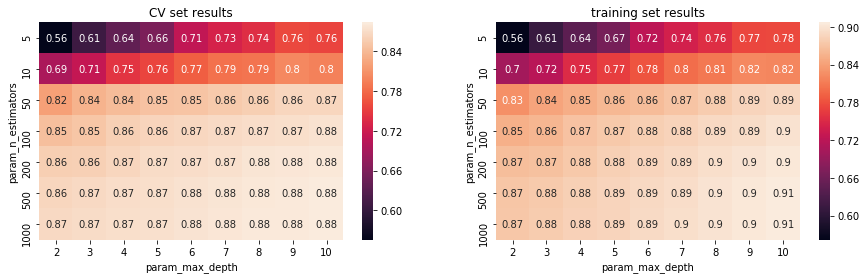

In [30]:
# get hyperparameter using gridsearchcv
get_best_hyperparameters_rf(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test)

In [18]:
#fit the model on test set
model_bow_rf = RandomForestClassifier(max_depth=10 , n_estimators= 1000, random_state= 507)
model_bow_rf.fit(X_train_bow,y_train)
y_pred = model_bow_rf.predict(X_test_bow)

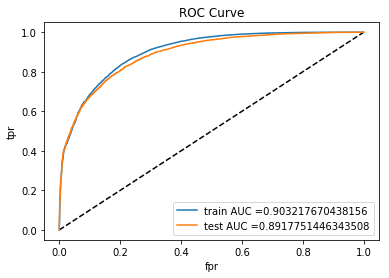

train AUC: 0.903217670438156
test AUC: 0.8917751446343508


In [19]:
# plot roc
auc_train_bow_rf, auc_test_bow_rf = plot_auc(model_bow_rf, X_train_bow, X_test_bow)

In [20]:
# confusion matrix
print_confusion_matrix(model_bow_rf, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[    4  9620]
 [    0 51817]]

*****Test confusion matrix*****
[[    0  4557]
 [    0 21775]]


<Figure size 432x288 with 0 Axes>

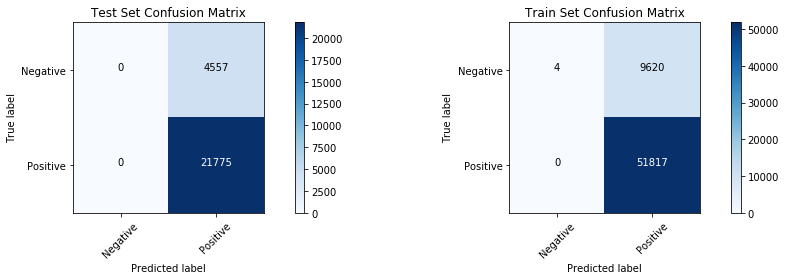

In [21]:
# heatmap of confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_rf.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_rf.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we calculated max_depth=10 , n_estimators= 1000 using GridSearchCV for the RandomForestClassifier. 
2. We got train AUC: 0.903217670438156 and test AUC: 0.8917751446343508
3. Using the confusion matrix, we can say that our model correctly predicted 21775 positive reviews and 0 negative reviews.
4. The model incorrectly classified 0 negative reviews and 4557 positive reviews.

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

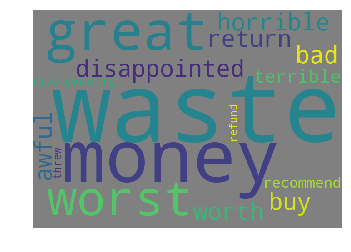

In [22]:
plot_word_cloud(bow_vectorizer,model_bow_rf )

**Feature Engineering** Let us perform FE to see if we can further improve the model. Here, we will append length of reviews as another feature.

In [23]:
def get_text_length(x):
    """
     This function takes in a array and returns the length of the elements in the array.
    """
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [24]:
rev_len_X_train = get_text_length(X_train)
rev_len_X_test = get_text_length(X_test)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer_fe = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer_fe.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=10,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer_fe.transform(X_train)
X_test_bow = bow_vectorizer_fe.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


**Standardize the data:** Not standardizing data as we are not dealing with distances.

In [ ]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

# from sklearn.preprocessing import StandardScaler
# X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
# X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

# print(X_train_bow.shape, y_train.shape) 

# print(X_test_bow.shape, y_test.shape) 

In [27]:
type(rev_len_X_train)


numpy.ndarray

In [28]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [29]:
from scipy.sparse import hstack
# Here we append the sparse matrix and the dense array that contains the length of the text passed to it
X_train_bow_fe = hstack((X_train_bow, np.array(rev_len_X_train)))
X_test_bow_fe = hstack((X_test_bow, np.array(rev_len_X_test)))

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.592     |   0.01777    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.635     |   0.01491    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.811     |   0.00793    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.853     |   0.01179    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.865     |   0.00887    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.864     |    0.0111    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.865     |   0.00938    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.677     |   0.01211    |   {'max_depth': 3, 'n_estimators': 5}   |
|      0.74     |   0.00835    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.838     |   0.00989    |   {'max_depth': 3, 'n_estimators': 50}  |
|      0.86     |   0.013

<Figure size 432x288 with 0 Axes>

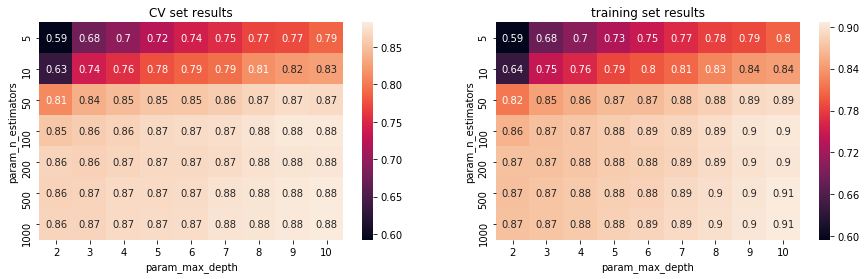

In [30]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
get_best_hyperparameters_rf(bow_vectorizer_fe, X_train_bow_fe, X_test_bow_fe, y_train, y_test)

In [31]:
model_bow_fe = RandomForestClassifier(max_depth= 10, n_estimators= 1000, random_state= 507)
model_bow_fe.fit(X_train_bow_fe,y_train)
y_pred = model_bow_fe.predict(X_test_bow_fe)

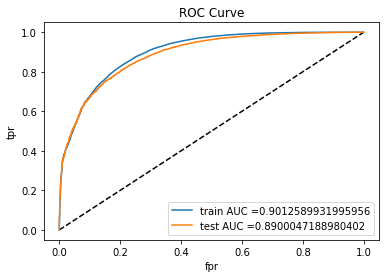

train AUC: 0.9012589931995956
test AUC: 0.8900047188980402


In [32]:
# AUC-ROC plot
auc_train_bow_fe, auc_test_bow_fe = plot_auc(model_bow_fe, X_train_bow_fe, X_test_bow_fe)

In [33]:
# Confusion Matrix
print_confusion_matrix(model_bow_fe, X_train_bow_fe, X_test_bow_fe)

*****Train confusion matrix*****
[[    4  9620]
 [    0 51817]]

*****Test confusion matrix*****
[[    0  4557]
 [    0 21775]]


<Figure size 432x288 with 0 Axes>

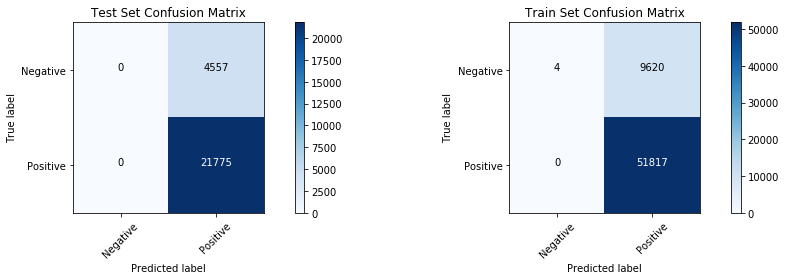

In [34]:
# Confustion Matrix heatmap
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_fe.predict(X_test_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_fe.predict(X_train_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For this BoW vectorizer, we performed feature engineering and calculated max_depth= 10, n_estimators= 1000 using GridSearchCV for the RandomForestClassifier. 
2. We got train AUC: 0.9012589931995956 and test AUC: 0.8900047188980402
3. Using the confusion matrix, we can say that our model correctly predicted 21775 positive reviews and 0 negative reviews.
4. The model incorrectly classified 0 negative reviews and 4557 positive reviews.


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [47]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
#X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
#print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 36173) (61441,)
(26332, 36173) (26332,)


In [48]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text TFIDF vectorizer  (61441, 36173)
the number of unique words:  36173


## [5.2] Applying Random Forest on TFIDF,<font color='red'> SET 2</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|      0.57     |   0.03355    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.637     |   0.02375    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.797     |   0.01615    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.833     |   0.00194    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.856     |   0.00049    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.877     |   0.01077    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.885     |   0.00932    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.599     |   0.03185    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.671     |   0.02252    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.818     |   0.01403    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.852     |   0.008

<Figure size 432x288 with 0 Axes>

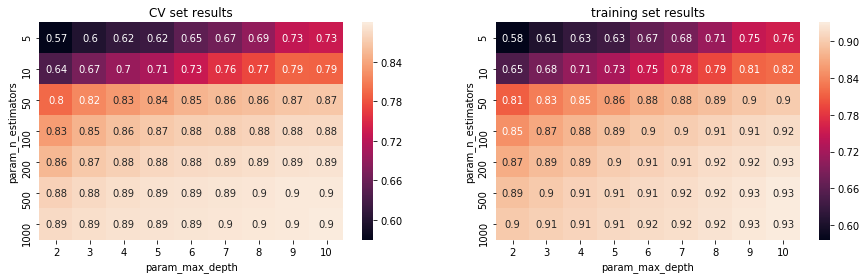

In [36]:
# Get the best hyperparameter using GridSearchCV 
get_best_hyperparameters_rf(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [37]:
# Fitting the model with the best hyperparameter
model_tfidf_rf = RandomForestClassifier(max_depth= 10, n_estimators= 1000, random_state= 507)
model_tfidf_rf.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_rf.predict(X_test_tfidf)

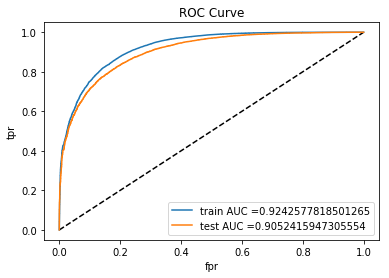

train AUC: 0.9242577818501265
test AUC: 0.9052415947305554


In [38]:
# AUC- ROC plot
auc_train_tfidf_rf, auc_test_tfidf_rf = plot_auc(model_tfidf_rf, X_train_tfidf, X_test_tfidf)

In [39]:
# Confusion Matrix
print_confusion_matrix(model_tfidf_rf, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[    0  9624]
 [    0 51817]]

*****Test confusion matrix*****
[[    0  4557]
 [    0 21775]]


<Figure size 432x288 with 0 Axes>

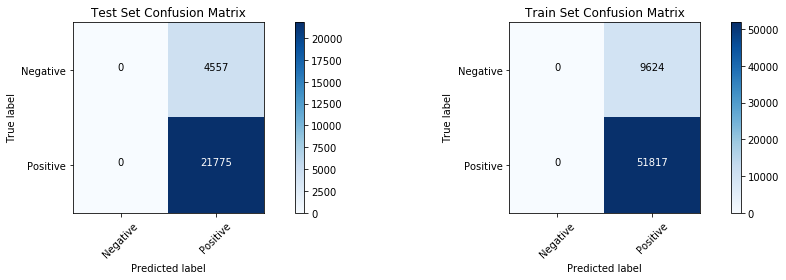

In [40]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_rf.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_rf.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF vectorizer, we calculated max_depth= 10, n_estimators= 1000 using GridSearchCV for the RandomForestClassifier. 
2. We got train AUC: 0.9242577818501265 and test AUC: 0.9052415947305554
3. Using the confusion matrix, we can say that our model correctly predicted 21775 positive reviews and 0 negative reviews.
4. The model incorrectly classified 0 negative reviews and 4557 positive reviews.

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

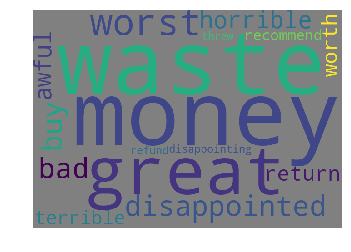

In [42]:
plot_word_cloud(tf_idf_vect, model_tfidf_rf)

## [4.4] Word2Vec

In [15]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [16]:
print(list_of_sentance_train[0])

['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching']


In [17]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8394320011138916), ('awesome', 0.8241457939147949), ('good', 0.8143970966339111), ('wonderful', 0.7911968231201172), ('excellent', 0.7892639636993408), ('terrific', 0.7644124627113342), ('perfect', 0.7631816864013672), ('fabulous', 0.7199209928512573), ('amazing', 0.7104012966156006), ('nice', 0.7021403312683105)]
[('greatest', 0.7678155899047852), ('best', 0.7451759576797485), ('nastiest', 0.7386510372161865), ('tastiest', 0.7325270175933838), ('closest', 0.6756479740142822), ('disgusting', 0.6497133374214172), ('toughest', 0.5985434055328369), ('coolest', 0.5932610034942627), ('shiniest', 0.593137264251709), ('smoothest', 0.5921728610992432)]


In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


**Converting train text data**

In [19]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [01:40<00:00, 609.12it/s]


(61441, 50)
[ 0.29067609  0.52428607 -0.32532657 -0.14083579  0.48325848 -0.26560335
  0.10066516 -0.16719092  0.19929624  0.06948225  0.34426193 -0.62500885
 -0.38897409 -0.31817215  0.24437881  0.01289248  0.23596345 -0.34582444
 -0.00645962  0.09037118  0.09698521 -1.08202749 -0.16414414 -0.513
 -0.25876456 -0.00927504 -0.02899186  0.43196568 -0.39100405 -0.02346253
 -0.04247275 -0.62393324  0.37025943 -0.21555966 -0.17350822  0.47798262
 -0.32093537  0.20410479 -0.16105592  0.52386177 -0.11883579  0.04648027
 -0.26614846 -0.22864075  0.05735443  0.23017308 -0.11808634 -0.38006807
 -0.14096403  0.06272415]


**Converting test text data**

In [20]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [21]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [00:47<00:00, 553.31it/s]


(26332, 50)
[ 7.32779572e-02 -3.46136702e-01 -6.54914675e-01  1.47750129e-01
  1.23298011e-01 -4.60628436e-01  4.51817571e-01 -2.43731275e-01
  6.86988558e-01 -2.39668348e-02  5.01684148e-01  6.30068979e-01
  1.55763789e-03 -2.60103055e-01 -1.87938026e-01 -8.37190652e-01
 -1.07787604e+00 -3.87229630e-01 -1.30880410e+00 -3.84935185e-01
 -2.53689286e-01 -4.03154008e-01  1.07250756e-02  5.46280895e-02
 -2.70660606e-01  3.12555090e-01  5.29109994e-01 -8.77271242e-03
  3.83638387e-01 -1.26101676e+00 -4.69558629e-01  1.38281945e+00
  1.93468877e-01 -5.02825131e-01 -2.24848013e-01  2.91805726e-01
 -1.78917092e-01 -5.92434287e-01  1.04352609e-01  2.61748786e-04
 -5.77283283e-01  1.07920707e-01 -3.86759694e-01 -8.15948226e-01
  2.81434349e-01  3.13603798e-01  4.90470884e-02 -5.17845435e-01
 -1.73990989e-01  1.98179977e-01]


## [5.3] Applying Random Forest on AVG W2V,<font color='red'> SET 3</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.807     |   0.01031    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.823     |   0.00956    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.838     |   0.00752    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.839     |   0.00738    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.842     |   0.00921    |  {'max_depth': 2, 'n_estimators': 200}  |
|      0.84     |   0.00904    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.841     |   0.01012    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.819     |   0.01788    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.842     |   0.00946    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.852     |   0.01228    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.854     |   0.010

Text(0.5,1,'training set results')

<Figure size 432x288 with 0 Axes>

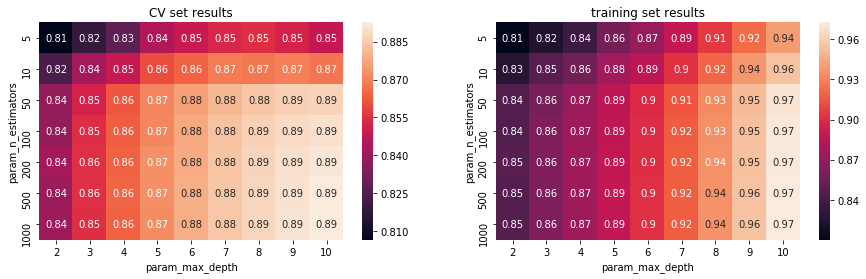

In [41]:
params_dict = {
                "max_depth": [2,3,4,5,6,7,8,9,10], 
                "n_estimators": [5,10,50,100,200,500,1000]
                  }    
clf = RandomForestClassifier(random_state= 507)
   
# Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

gs_obj.fit(sent_vectors_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 
del(t1)

print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))
#print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
#plotting heatmap
# https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
plt.figure(1)
plt.figure(figsize=(15, 4))
    
plt.subplot(121)
pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
    
ax = sns.heatmap(pvt,annot = True)
ax.set_title("CV set results")
    
plt.subplot(122) 
pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
    
ax2 = sns.heatmap(pvt2,annot = True, )
ax2.set_title('training set results')

In [22]:
# Fitting the model with the best hyperparameter
model_avgw2v_rf = RandomForestClassifier(max_depth= 10, n_estimators= 1000, random_state= 507)
model_avgw2v_rf.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_rf.predict(sent_vectors_test)

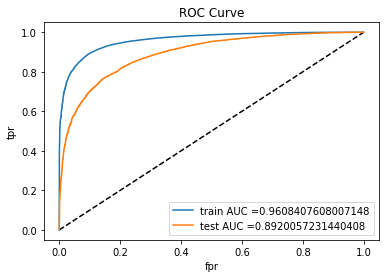

train AUC: 0.9608407608007148
test AUC: 0.8920057231440408


In [23]:
# AUC - ROC plot
auc_train_avgw2v_rf, auc_test_avgw2v_rf = plot_auc(model_avgw2v_rf, sent_vectors_train, sent_vectors_test)

In [24]:
# Confusion matrix
print_confusion_matrix(model_avgw2v_rf, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 3721  5903]
 [  352 51465]]

*****Test confusion matrix*****
[[ 1198  3359]
 [  278 21497]]


<Figure size 432x288 with 0 Axes>

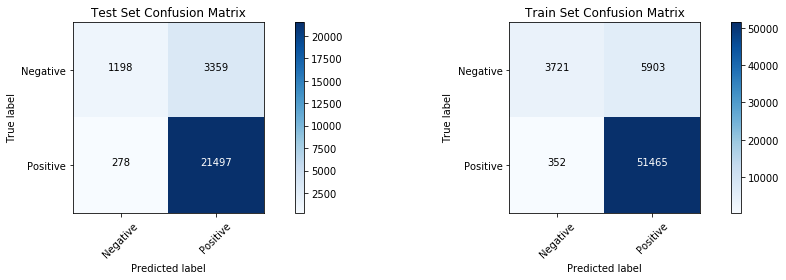

In [25]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_rf.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_rf.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the Avg W2V vectorizer, we calculated max_depth= 10, n_estimators= 1000 using GridSearchCV for the RandomForestClassifier. 
2. We got train AUC: 0.9608407608007148 and test AUC: 0.8920057231440408
3. Using the confusion matrix, we can say that our model correctly predicted 21497 positive reviews and 1198 negative reviews.
4. The model incorrectly classified 278 negative reviews and 3359 positive reviews.


#### [4.4.1.2] TFIDF weighted W2v

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [27]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [24:01<00:00, 33.81it/s]


In [28]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [10:38<00:00, 41.25it/s]


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.771     |   0.00843    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.791     |    0.0078    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.804     |   0.00307    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.808     |   0.00582    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.811     |   0.00851    |  {'max_depth': 2, 'n_estimators': 200}  |
|      0.81     |   0.00846    |  {'max_depth': 2, 'n_estimators': 500}  |
|      0.81     |   0.00999    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.786     |   0.02134    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.809     |   0.00944    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.821     |   0.00946    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.825     |   0.008

<Figure size 432x288 with 0 Axes>

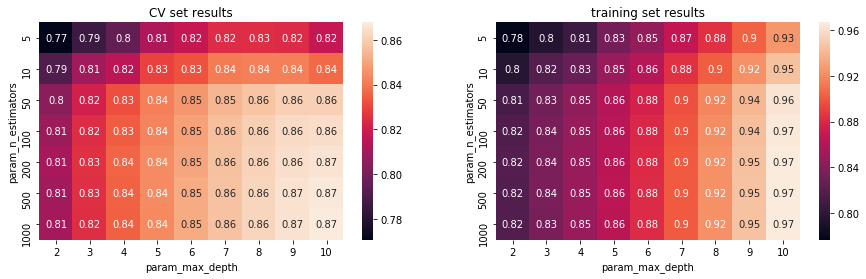

In [45]:
get_best_hyperparameters_rf(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test)

In [29]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v_rf = RandomForestClassifier(max_depth=10 , n_estimators= 1000, random_state= 507)
model_tfidfw2v_rf.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_rf.predict(tfidf_sent_vectors_test)

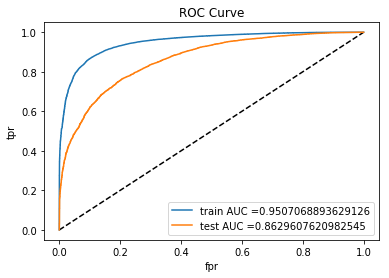

train AUC: 0.9507068893629126
test AUC: 0.8629607620982545


In [30]:
# AUC- ROC plot
auc_train_tfidfw2v_rf, auc_test_tfidfw2v_rf = plot_auc(model_tfidfw2v_rf, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [31]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_rf, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 2835  6789]
 [  265 51552]]

*****Test confusion matrix*****
[[  907  3650]
 [  236 21539]]


<Figure size 432x288 with 0 Axes>

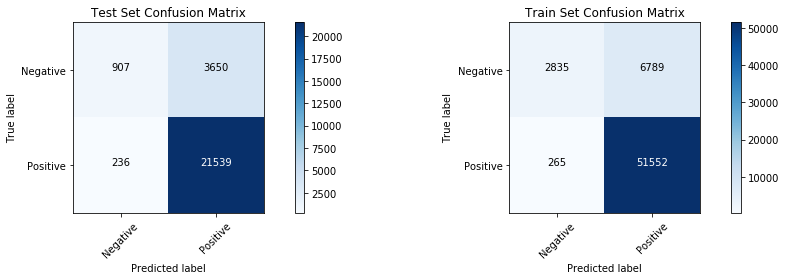

In [32]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_rf.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_rf.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF- weighted W2V vectorizer, we calculated 'max_depth': 10, 'n_estimators': 1000 using GridSearchCV for the RandomForestClassifier. 
2. We got train AUC: 0.9507068893629126 and test AUC: 0.8629607620982545
3. Using the confusion matrix, we can say that our model correctly predicted 21539 positive reviews and 907 negative reviews.
4. The model incorrectly classified 236 negative reviews and 3650 positive reviews.

### GBDT using xgboost/ lightgbm

In [ ]:
#del final
#, X_train_bow, X_test_bow,X_train_bow_fe, X_test_bow_fe, X,y

#del X_train_tfidf, X_test, y_train, y_test#, X_train_bow, X_test_bow,X_train_bow_fe, X_test_bow_fe
#del w2v_words, tfidf_feat, tfidf_sent_vectors_test, tfidf_sent_vectors_train, sent_vectors_test, sent_vectors_train, sent_vec

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.702     |   0.01537    |   {'max_depth': 2, 'n_estimators': 5}   |
|      0.74     |   0.02529    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.826     |   0.02051    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.864     |   0.01747    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.894     |   0.01408    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.922     |   0.00921    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.936     |   0.00826    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.731     |   0.01174    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.753     |   0.02138    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.849     |   0.01695    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.883     |   0.013

<Figure size 432x288 with 0 Axes>

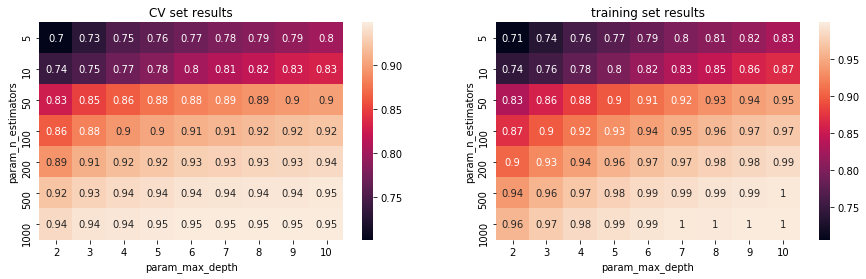

In [22]:
get_best_hyperparameters_xgb(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test)

In [53]:
#fit the model on test set
model_bow_xgb = XGBClassifier(max_depth=8 , n_estimators= 1000, random_state= 507)
model_bow_xgb.fit(X_train_bow,y_train)
y_pred = model_bow_xgb.predict(X_test_bow)

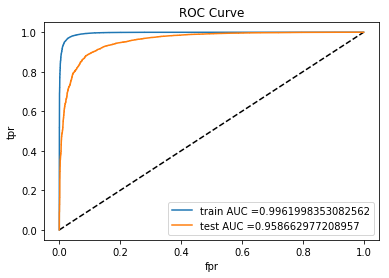

train AUC: 0.9961998353082562
test AUC: 0.958662977208957


In [54]:
# plot roc
auc_train_bow_xgb, auc_test_bow_xgb = plot_auc(model_bow_xgb, X_train_bow, X_test_bow)

In [55]:
# confusion matrix
print_confusion_matrix(model_bow_xgb, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 8361  1263]
 [  134 51683]]

*****Test confusion matrix*****
[[ 2972  1585]
 [  432 21343]]


<Figure size 432x288 with 0 Axes>

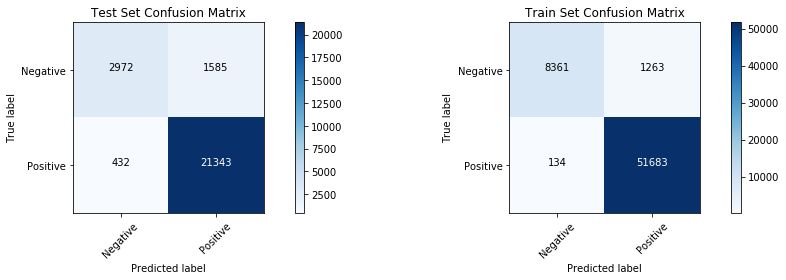

In [56]:
# heatmap of confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_xgb.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_xgb.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we calculated max_depth=8 , n_estimators= 1000 using GridSearchCV for the xgboostclassifier. 
2. We got train AUC: 0.9961998353082562 and test AUC: 0.958662977208957
3. Using the confusion matrix, we can say that our model correctly predicted 21343 positive reviews and 2972 negative reviews.
4. The model incorrectly classified 432 negative reviews and 1585 positive reviews.

### [5.2.2] Applying lightgbm on TFIDF,<font color='red'> SET 2</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.724     |   0.02742    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.751     |   0.02582    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.836     |   0.01936    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.869     |   0.01603    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.897     |    0.0134    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.925     |   0.01164    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.938     |   0.00982    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.741     |   0.02647    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.776     |   0.01476    |   {'max_depth': 3, 'n_estimators': 10}  |
|      0.86     |    0.0181    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.889     |    0.01

<Figure size 432x288 with 0 Axes>

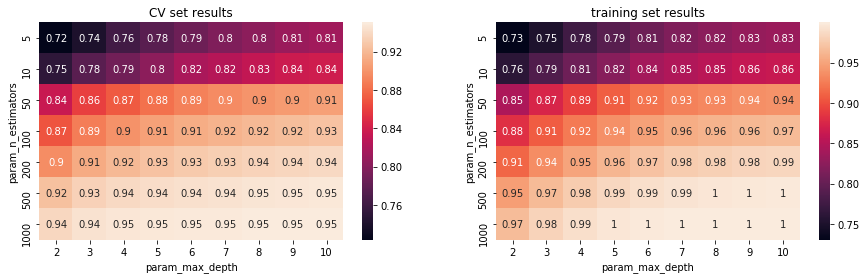

In [18]:
get_best_hyperparameters_lgbm(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [49]:
# Fitting the model with the best hyperparameter
model_tfidf_lgbm = LGBMClassifier(boosting_type = 'gbdt', max_depth=10 , n_estimators= 1000, objective = 'binary', silent = True, random_state= 507)
model_tfidf_lgbm.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_lgbm.predict(X_test_tfidf)

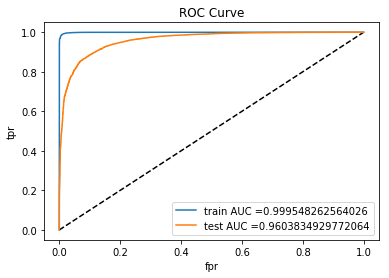

train AUC: 0.999548262564026
test AUC: 0.9603834929772064


In [50]:
# AUC- ROC plot
auc_train_tfidf_lgbm, auc_test_tfidf_lgbm = plot_auc(model_tfidf_lgbm, X_train_tfidf, X_test_tfidf)

In [51]:
# Confusion Matrix
print_confusion_matrix(model_tfidf_lgbm, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 9032   592]
 [   53 51764]]

*****Test confusion matrix*****
[[ 3033  1524]
 [  441 21334]]


<Figure size 432x288 with 0 Axes>

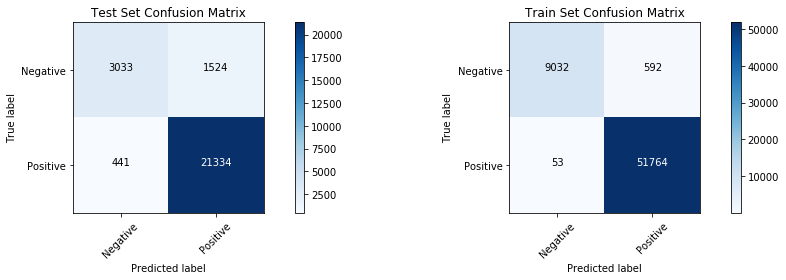

In [52]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf_lgbm.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf_lgbm.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF vectorizer, we calculated m max_depth=10 , n_estimators= 1000 using GridSearchCV for the lightgbm. 
2. We got train AUC: 0.999548262564026 and test AUC: 0.9603834929772064
3. Using the confusion matrix, we can say that our model correctly predicted 21334 positive reviews and 3033 negative reviews.
4. The model incorrectly classified 441 negative reviews and 1524 positive reviews.

### [5.2.3] Applying lightgbm on AVG W2V,<font color='red'> SET 3</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|      0.79     |   0.03783    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.823     |    0.0283    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.873     |   0.01563    |   {'max_depth': 2, 'n_estimators': 50}  |
|     0.888     |   0.01222    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.899     |   0.01018    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.907     |   0.00869    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.909     |   0.00891    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.817     |   0.03014    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.842     |   0.02314    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.885     |   0.01335    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.898     |   0.009

Text(0.5,1,'training set results')

<Figure size 432x288 with 0 Axes>

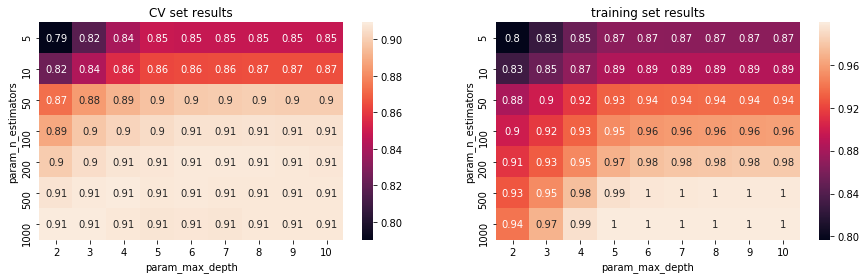

In [33]:
params_dict = {
                "max_depth": [2,3,4,5,6,7,8,9,10], 
                "n_estimators": [5,10,50,100,200,500,1000]
                  }
    
clf = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', silent = True, random_state= 507)
   
    # Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

gs_obj.fit(sent_vectors_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 
del(t1)

print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))
#print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
#plotting heatmap
# https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
plt.figure(1)
plt.figure(figsize=(15, 4))
    
plt.subplot(121)
pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
    
ax = sns.heatmap(pvt,annot = True)
ax.set_title("CV set results")
    
plt.subplot(122) 
pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_n_estimators', columns='param_max_depth')
    
ax2 = sns.heatmap(pvt2,annot = True, )
ax2.set_title('training set results')

In [41]:
# Fitting the model with the best hyperparameter
model_avgw2v_lgbm = LGBMClassifier(boosting_type = 'gbdt', max_depth=4 , n_estimators= 500, objective = 'binary', silent = True, random_state= 507)
model_avgw2v_lgbm.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v_lgbm.predict(sent_vectors_test)

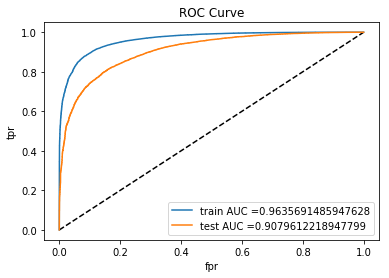

train AUC: 0.9635691485947628
test AUC: 0.9079612218947799


In [42]:
# AUC - ROC plot
auc_train_avgw2v_lgbm, auc_test_avgw2v_lgbm = plot_auc(model_avgw2v_lgbm, sent_vectors_train, sent_vectors_test)

In [43]:
# Confusion matrix
print_confusion_matrix(model_avgw2v_lgbm, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 6265  3359]
 [ 1075 50742]]

*****Test confusion matrix*****
[[ 2325  2232]
 [  862 20913]]


<Figure size 432x288 with 0 Axes>

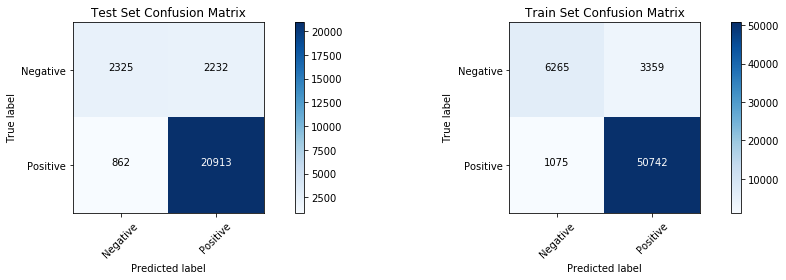

In [44]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v_lgbm.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v_lgbm.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the Avg W2V vectorizer, we calculated max_depth=4 , n_estimators= 500 using GridSearchCV for the lightgbm.
2. We got train AUC: 0.9635691485947628 and test AUC: 0.9079612218947799
3. Using the confusion matrix, we can say that our model correctly predicted 20913 positive reviews and 2325 negative reviews.
4. The model incorrectly classified 862 negative reviews and 2232 positive reviews.


### [5.2.4] Applying lightgbm on TFIDF W2V,<font color='red'> SET 4</font>

+---------------+--------------+-----------------------------------------+
| Mean CV Score | Std CV Score |                  Param                  |
+---------------+--------------+-----------------------------------------+
|     0.769     |   0.04547    |   {'max_depth': 2, 'n_estimators': 5}   |
|     0.794     |   0.03181    |   {'max_depth': 2, 'n_estimators': 10}  |
|     0.844     |   0.01965    |   {'max_depth': 2, 'n_estimators': 50}  |
|      0.86     |    0.0165    |  {'max_depth': 2, 'n_estimators': 100}  |
|     0.873     |   0.01374    |  {'max_depth': 2, 'n_estimators': 200}  |
|     0.884     |   0.01073    |  {'max_depth': 2, 'n_estimators': 500}  |
|     0.888     |   0.01108    |  {'max_depth': 2, 'n_estimators': 1000} |
|     0.793     |   0.02676    |   {'max_depth': 3, 'n_estimators': 5}   |
|     0.814     |   0.02507    |   {'max_depth': 3, 'n_estimators': 10}  |
|     0.858     |   0.01751    |   {'max_depth': 3, 'n_estimators': 50}  |
|     0.872     |    0.01

<Figure size 432x288 with 0 Axes>

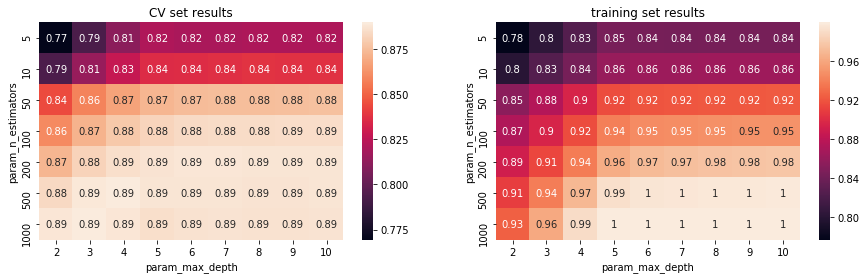

In [35]:
get_best_hyperparameters_lgbm(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test)

In [37]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v_lgbm = LGBMClassifier(boosting_type = 'gbdt', max_depth=3 , n_estimators= 1000, objective = 'binary', silent = True, random_state= 507)
model_tfidfw2v_lgbm.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v_rf.predict(tfidf_sent_vectors_test)

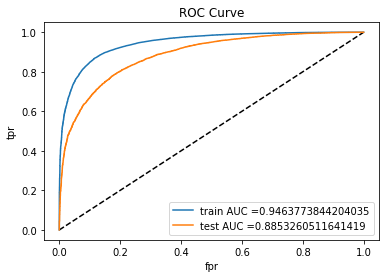

train AUC: 0.9463773844204035
test AUC: 0.8853260511641419


In [38]:
# AUC- ROC plot
auc_train_tfidfw2v_lgbm, auc_test_tfidfw2v_lgbm = plot_auc(model_tfidfw2v_lgbm, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [39]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v_lgbm, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 5489  4135]
 [ 1141 50676]]

*****Test confusion matrix*****
[[ 2036  2521]
 [  851 20924]]


<Figure size 432x288 with 0 Axes>

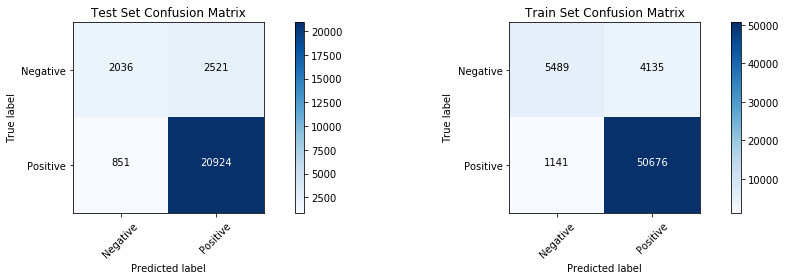

In [40]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v_lgbm.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v_lgbm.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF- weighted W2V vectorizer, we calculated max_depth=3 and n_estimators= 1000 using GridSearchCV for the lightgbm. 
2. We got train AUC: 0.9463773844204035 and test AUC: 0.8853260511641419
3. Using the confusion matrix, we can say that our model correctly predicted 20924 positive reviews and 2036 negative reviews.
4. The model incorrectly classified 851 negative reviews and 2521 positive reviews.

# [6] Conclusions

In [64]:
C = PrettyTable()

C.field_names = ['Sr. No', 'Vectorizer','algorithm','max_depth',' n_estimators', 'Train AUC', 'Test AUC']
C.add_row([1, 'BoW', 'Random Forest',10 , 1000,0.903217670438156, 0.8917751446343508])
C.add_row([2, 'TF_IDF', 'Random Forest', 10,1000 ,0.9242577818501265,0.9052415947305554])
C.add_row([3, 'Avg-W2V', 'Random Forest', 10, 1000,auc_train_avgw2v_rf, auc_test_avgw2v_rf])
C.add_row([4, 'TFIDF-W2V', 'Random Forest', 10,1000 ,auc_train_tfidfw2v_rf, auc_test_tfidfw2v_rf])
C.add_row([5, 'BoW', 'GBDT using xgboost', 8,1000 ,auc_train_bow_xgb, auc_test_bow_xgb])
C.add_row([6, 'TF_IDF', 'GBDT using lightgbm',10 ,1000 ,auc_train_tfidf_lgbm, auc_test_tfidf_lgbm])
C.add_row([7, 'Avg-W2V', 'GBDT using lightgbm', 4, 500 ,auc_train_avgw2v_lgbm, auc_test_avgw2v_lgbm])
C.add_row([8, 'TFIDF-W2V', 'GBDT using lightgbm',3 ,1000 ,auc_train_tfidfw2v_lgbm, auc_test_tfidfw2v_lgbm])
           

print(C)
del C

+--------+------------+---------------------+-----------+---------------+--------------------+--------------------+
| Sr. No | Vectorizer |      algorithm      | max_depth |  n_estimators |     Train AUC      |      Test AUC      |
+--------+------------+---------------------+-----------+---------------+--------------------+--------------------+
|   1    |    BoW     |    Random Forest    |     10    |      1000     | 0.903217670438156  | 0.8917751446343508 |
|   2    |   TF_IDF   |    Random Forest    |     10    |      1000     | 0.9242577818501265 | 0.9052415947305554 |
|   3    |  Avg-W2V   |    Random Forest    |     10    |      1000     | 0.9608407608007148 | 0.8920057231440408 |
|   4    | TFIDF-W2V  |    Random Forest    |     10    |      1000     | 0.9507068893629126 | 0.8629607620982545 |
|   5    |    BoW     |  GBDT using xgboost |     8     |      1000     | 0.9961998353082562 | 0.958662977208957  |
|   6    |   TF_IDF   | GBDT using lightgbm |     10    |      1000     

## Summary

1. Implemented Random Forest and Gradient Boosted Decision Tree Classifiers on the Amazon fine food dataset. 
2. Made use of GridSearchCV to find the best value of max_depth and n_esitmators.
3. Performed Feature Engineering on the BoW model and found out the model slightly performed worse.
4. Different vectors take on different hyperparameter values. We saw values being taken from 
        "max_depth": [2,3,4,5,6,7,8,9,10], 
        "n_estimators": [5,10,50,100,200,500,1000]
5. We visualize the top 20 important features using the wordcloud for BoW and TF-IDF.
6. For the GBDT part, we experimented with sklearn's RandomForestClassifier and Microsoft's lightgbm
7. We observe that GBDT performed better than RandomForest on this dataset.